# EDAN95 - Applied Machine Learning
### LTH Fall 2019

# Lab 4
### David Larsson & Jonas Lundgren

### GloVe embeddings

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
def read_GloVe(path = "data/glove.6B.100d.txt"):
    """
    Function that reads GloVe embeddings and returns a dictionary, 
    where the keys will be the words and the values, the embeddings.
    """
    d = {}
    with open(path) as f:
        for embeddings in f:
            embeddings_list = embeddings.split()
            d[embeddings_list[0]] = np.array([float(i) for i in embeddings_list[1:]])
            
    return d

In [4]:
glove_dict = read_GloVe()

In [5]:
def cosine_sim(word, glove_dict = glove_dict, num_closest = 5):
    """
    Using a cosine similarity, computes the num_closest 
    closest words to word in glove_dict
    """
    A = glove_dict[str(word)]
    A_norm = np.linalg.norm(A, 2)
    
    cos_sims = np.zeros(len(glove_dict))
    
    for i, (k, v) in enumerate(glove_dict.items()):
        if k != word:
            B = v
            B_norm = np.linalg.norm(B, 2)
    
            cos_sim = A.dot(B) / (A_norm * B_norm)
            cos_sims[i] = cos_sim
    
    max_idxs = list(cos_sims.argsort()[-num_closest:])
    
    return [list(glove_dict.keys())[i] for i in max_idxs]

In [6]:
print("Closest 5 words to table :", cosine_sim('table'))
print("Closest 5 words to table :", cosine_sim('france'))
print("Closest 5 words to table :", cosine_sim('sweden'))

Closest 5 words to table : ['side', 'room', 'bottom', 'place', 'tables']
Closest 5 words to table : ['paris', 'spain', 'britain', 'french', 'belgium']
Closest 5 words to table : ['austria', 'netherlands', 'finland', 'norway', 'denmark']


## Load Files

In [8]:
BASE_DIR = r'/home/jonas/projects/edan95/Lab4/data'


def load_conll2003_en():
    train_file = BASE_DIR + '/eng.train'
    dev_file = BASE_DIR + '/eng.valid'
    test_file = BASE_DIR + '/eng.test'
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

In [9]:
train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()

Code from course github: https://github.com/pnugues/edan95/

In [10]:
import re

class Token(dict):
    pass

class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        rows = [row for row in rows if row[0] != '#']
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [11]:
conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

Named-entity recognition (NER) tags

In [12]:
train_dict[0]

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': 'O', 'ner': 'O'}]

In [13]:
def build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True):
    """
    Creates sequences from a list of dictionaries
    :param corpus_dict:
    :param key_x:
    :param key_y:
    :return: X, Y
    """
    X = []
    Y = []
    for sentence in corpus_dict:
        x = []
        y = []
        for word in sentence:
            x += [word[key_x]]
            y += [word[key_y]]
        if tolower:
            x = list(map(str.lower, x))
        X += [x]
        Y += [y]
    return X, Y

Should correspond with index 1 in X

In [14]:
X_train_cat, Y_train_cat = build_sequences(train_dict)
X_dev_cat, Y_dev_cat = build_sequences(dev_dict)
X_test_cat, Y_test_cat = build_sequences(test_dict)
print(X_train_cat[1])
print(Y_train_cat[1])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']


In [15]:
vocabulary_words = sorted(list(set([word for sentence in X_train_cat for word in sentence])))
ner = sorted(list(set([ner for sentence in Y_train_cat for ner in sentence])))

print(vocabulary_words[:10])
print(ner)

['!', '"', '$', '%', '&', "'", "'d", "'ll", "'m", "'re"]
['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


In [16]:
embeddings_words = sorted(glove_dict.keys())
embeddings_words[:10]

['!', '!!', '!!!', '!!!!', '!!!!!', '!?', '!?!', '"', '#', '##']

In [17]:
vocabulary_words = sorted(list(set(vocabulary_words + embeddings_words)))
vocabulary_words[:10]

['!', '!!', '!!!', '!!!!', '!!!!!', '!?', '!?!', '"', '#', '##']

In [18]:
tok_words_reversed = dict(enumerate(vocabulary_words, start=2))
#0 reserved for padding
#1 reserved for words with unknown ner tag
tok_ners_reversed = dict(enumerate(ner, start=2))

In [19]:
tokenized_words = {v: k for k, v in tok_words_reversed.items()}
tokenized_ners = {v: k for k, v in tok_ners_reversed.items()}

print('word index:', list(tokenized_words.items())[:10])
print('\nNER index:', list(tokenized_ners.items())[:10])

word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11)]

NER index: [('B-LOC', 2), ('B-MISC', 3), ('B-ORG', 4), ('I-LOC', 5), ('I-MISC', 6), ('I-ORG', 7), ('I-PER', 8), ('O', 9)]


In [20]:
def sentences_to_idx(X, tokenized_x):
    X_idxs = []
    for sentence in X:
        #Map unknowns to 1
        X_idxs.append([tokenized_x[x] if x in tokenized_x else 1 for x in sentence])
        
    return X_idxs

In [21]:
X_idx = sentences_to_idx(X_train_cat, tokenized_words)
Y_idx = sentences_to_idx(Y_train_cat, tokenized_ners)

X_idx_dev = sentences_to_idx(X_dev_cat, tokenized_words)
Y_idx_dev = sentences_to_idx(Y_dev_cat, tokenized_ners)

X_idx_test = sentences_to_idx(X_test_cat, tokenized_words)
Y_idx_test = sentences_to_idx(Y_test_cat, tokenized_ners)

In [22]:
max_len = 150

In [23]:
X = pad_sequences(X_idx, maxlen = max_len)
Y = pad_sequences(Y_idx, maxlen = max_len)

print(X.shape)
print(Y.shape)

(14987, 150)
(14987, 150)


In [24]:
X_dev = pad_sequences(X_idx_dev, maxlen = max_len)
Y_dev = pad_sequences(Y_idx_dev, maxlen = max_len)

X_test = pad_sequences(X_idx_test, maxlen = max_len)
Y_test = pad_sequences(Y_idx_test, maxlen = max_len)

In [25]:
Y_train = to_categorical(Y, num_classes = len(ner) + 2)
Y_dev = to_categorical(Y_dev, num_classes = len(ner) + 2)
Y_test = to_categorical(Y_test, num_classes = len(ner) + 2)

An example of how the padding works.

In [26]:
X[1]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [27]:
Y[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 6, 9, 9, 9, 6, 9, 9], dtype=int32)

In [36]:
Y[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8], dtype=int32)

Take a look at the distribution of the targets. Just counting the number of 0-9s in all Y vectors.

In [41]:
y_counts = np.zeros(10)
for y in Y:
    y_counts += np.bincount(y, minlength = 10)

y_counts

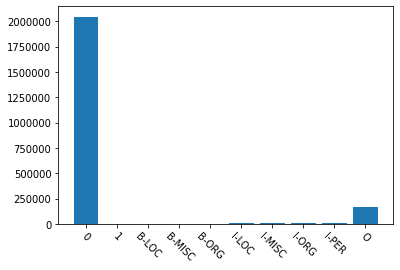

In [51]:
plt.bar(range(len(y_counts)), y_counts);
plt.xticks(range(len(y_counts)), [0, 1] + ner, rotation=-45);

We see that the distribution is skewed.

## Building the Embedding Matrix

In [29]:
EMBEDDINGS_DIM = len(glove_dict[list(glove_dict.keys())[0]])

embedding_matrix = np.random.randn(len(vocabulary_words) + 2, EMBEDDINGS_DIM)

In [30]:
for word in vocabulary_words:
    if word in glove_dict:
        embedding_matrix[tokenized_words[word]] = glove_dict[word]

## Saving for conlleval

In [31]:
def save(file, corpus_dict, ner, y_preds, y_reals):
    
    with open(file, 'w', encoding='utf8') as f_out:
        for i, sentence in enumerate(corpus_dict):
            sentence_lst = []
            for j, row in enumerate(sentence):
                items = str(row.get('form')) + ' ' + str(ner[y_reals[i][j]- 2]) + ' ' + str(ner[y_preds[i][j] - 2])
                sentence_lst += items + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

## Building a Simple Recurrent Neural Network

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, Dropout
from keras import optimizers

In [33]:
model = Sequential()
model.add(Embedding(len(vocabulary_words) + 2, 
                    EMBEDDINGS_DIM, 
                    input_length = max_len, 
                    mask_zero = True))
model.add(SimpleRNN(EMBEDDINGS_DIM, return_sequences = True))
model.add(Dense(units = len(ner) + 2, activation = 'softmax'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 150, 100)          20100     
_________________________________________________________________
dense_1 (Dense)              (None, 150, 10)           1010      
Total params: 40,280,810
Trainable params: 40,280,810
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer = optimizers.RMSprop(),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [35]:
retrain_model = True
if retrain_model:
    history = model.fit(X, Y_train,
                    epochs = 5,
                    batch_size = 256,
                    validation_data = (X_dev, Y_dev))

/home/jonas/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14987 samples, validate on 3466 samples
Epoch 1/5
14987/14987 [==============================] - 43s 3ms/step - loss: 0.0474 - acc: 0.8539 - val_loss: 0.0309 - val_acc: 0.9052
Epoch 2/5
14987/14987 [==============================] - 42s 3ms/step - loss: 0.0217 - acc: 0.9295 - val_loss: 0.0214 - val_acc: 0.9350
Epoch 3/5
14987/14987 [==============================] - 38s 3ms/step - loss: 0.0164 - acc: 0.9457 - val_loss: 0.0195 - val_acc: 0.9428
Epoch 4/5
14987/14987 [==============================] - 37s 2ms/step - loss: 0.0138 - acc: 0.9538 - val_loss: 0.0165 - val_acc: 0.9503
Epoch 5/5
14987/14987 [==============================] - 41s 3ms/step - loss: 0.0121 - acc: 0.9589 - val_loss: 0.0161 - val_acc: 0.9523


In [36]:
if retrain_model:
    model.save_weights('model_1_lab4.model')
else:
    model.load_weights('model_1_lab4.model')

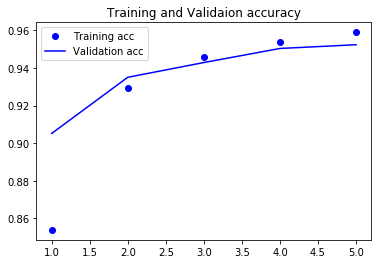

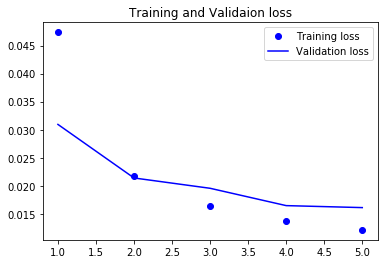

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [38]:
test_loss, test_acc = model.evaluate(X_test, Y_test)

3684/3684 [==============================] - 1s 404us/step


In [39]:
print("Test loss :", test_loss)
print("Test acc  :", test_acc)

Test loss : 0.01772723544892591
Test acc  : 0.9332062005996704


In [40]:
Y_pred = model.predict(X_test)
Y_preds = np.argmax(Y_pred, axis = 2)

In [41]:
np.shape(np.argmax(Y_test, axis = 2))

(3684, 150)

In [42]:
Y_test_ = [y[y != 0.] for y in np.argmax(Y_test, axis = 2)]
Y_pred_ = [y_hat[y != 0.] for y, y_hat in zip(np.argmax(Y_test, axis = 2), Y_preds)]

In [43]:
print("True values      :", Y_test_[1])
print("Predicted values :", Y_pred_[1])

True values      : [9 9 5 9 9 9 9 8 9 9 9 9]
Predicted values : [9 9 5 9 9 9 9 5 9 9 9 9]


In [44]:
save("output1.txt", test_dict, ner, Y_test_, Y_pred_)

## LSTM

In [45]:
model2 = Sequential()
model2.add(Embedding(len(vocabulary_words) + 2, 
                    EMBEDDINGS_DIM, 
                    input_length = max_len, 
                    mask_zero = True))
model2.add(LSTM(EMBEDDINGS_DIM, return_sequences = True))
model2.add(Dropout(0.5))
model2.add(Dense(units = len(ner) + 2, activation = 'softmax'))

model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = True

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 150, 10)           1010      
Total params: 40,341,110
Trainable params: 40,341,110
Non-trainable params: 0
_________________________________________________________________


In [46]:
model2.compile(optimizer = optimizers.RMSprop(),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [47]:
retrain_model = True
if retrain_model:
    history = model2.fit(X, Y_train,
                    epochs = 5,
                    batch_size = 256,
                    validation_data = (X_dev, Y_dev))

/home/jonas/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14987 samples, validate on 3466 samples
Epoch 1/5
14987/14987 [==============================] - 65s 4ms/step - loss: 0.0605 - acc: 0.8299 - val_loss: 0.0387 - val_acc: 0.8894
Epoch 2/5
14987/14987 [==============================] - 59s 4ms/step - loss: 0.0283 - acc: 0.9099 - val_loss: 0.0246 - val_acc: 0.9278
Epoch 3/5
14987/14987 [==============================] - 60s 4ms/step - loss: 0.0200 - acc: 0.9363 - val_loss: 0.0196 - val_acc: 0.9434
Epoch 4/5
14987/14987 [==============================] - 65s 4ms/step - loss: 0.0163 - acc: 0.9480 - val_loss: 0.0176 - val_acc: 0.9493
Epoch 5/5
14987/14987 [==============================] - 61s 4ms/step - loss: 0.0141 - acc: 0.9538 - val_loss: 0.0164 - val_acc: 0.9523


In [48]:
if retrain_model:
    model2.save_weights('model_2_lab4.model')
else:
    model2.load_weights('model_2_lab4.model')

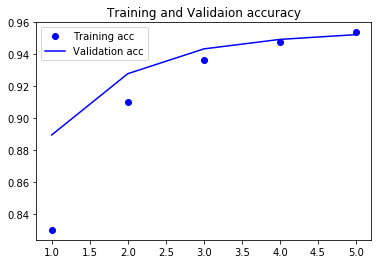

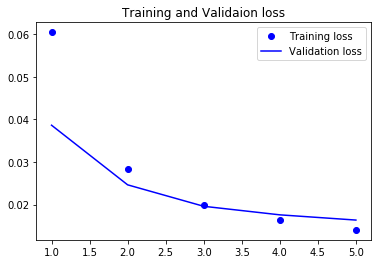

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [50]:
test_loss, test_acc = model2.evaluate(X_test, Y_test)

3684/3684 [==============================] - 3s 876us/step


In [51]:
print("Test loss :", test_loss)
print("Test acc  :", test_acc)

Test loss : 0.01638518374041127
Test acc  : 0.9386919736862183


In [52]:
Y_pred = model2.predict(X_test)
Y_preds = np.argmax(Y_pred, axis = 2)

In [53]:
np.shape(np.argmax(Y_test, axis = 2))

(3684, 150)

In [54]:
Y_test_ = [y[y != 0.] for y in np.argmax(Y_test, axis = 2)]
Y_pred_ = [y_hat[y != 0.] for y, y_hat in zip(np.argmax(Y_test, axis = 2), Y_preds)]

In [55]:
print("True values      :", Y_test_[1])
print("Predicted values :", Y_pred_[1])

True values      : [9 9 5 9 9 9 9 8 9 9 9 9]
Predicted values : [9 9 5 9 9 9 9 5 9 9 9 9]


In [56]:
save("output2.txt", test_dict, ner, Y_test_, Y_pred_)

### Model 3

In [57]:
from keras.layers import Bidirectional

In [58]:
model3 = Sequential()
model3.add(Embedding(len(vocabulary_words) + 2, 
                    EMBEDDINGS_DIM, 
                    input_length = max_len, 
                    mask_zero = True))
model3.add(Bidirectional(LSTM(EMBEDDINGS_DIM, return_sequences = True)))
model3.add(Dropout(0.5))
model3.add(Dense(units = len(ner) + 2, activation = 'softmax'))

model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = True

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 200)          160800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 150, 10)           2010      
Total params: 40,422,510
Trainable params: 40,422,510
Non-trainable params: 0
_________________________________________________________________


In [59]:
model3.compile(optimizer = optimizers.RMSprop(),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [60]:
retrain_model = True
if retrain_model:
    history = model3.fit(X, Y_train,
                    epochs = 5,
                    batch_size = 256,
                    validation_data = (X_dev, Y_dev))

/home/jonas/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14987 samples, validate on 3466 samples
Epoch 1/5
14987/14987 [==============================] - 94s 6ms/step - loss: 0.0485 - acc: 0.8506 - val_loss: 0.0289 - val_acc: 0.9080
Epoch 2/5
14987/14987 [==============================] - 96s 6ms/step - loss: 0.0217 - acc: 0.9284 - val_loss: 0.0193 - val_acc: 0.9387
Epoch 3/5
14987/14987 [==============================] - 95s 6ms/step - loss: 0.0156 - acc: 0.9488 - val_loss: 0.0158 - val_acc: 0.9516
Epoch 4/5
14987/14987 [==============================] - 108s 7ms/step - loss: 0.0126 - acc: 0.9579 - val_loss: 0.0139 - val_acc: 0.9566
Epoch 5/5
14987/14987 [==============================] - 126s 8ms/step - loss: 0.0107 - acc: 0.9639 - val_loss: 0.0131 - val_acc: 0.9577


In [61]:
if retrain_model:
    model3.save_weights('model_3_lab4.model')
else:
    model3.load_weights('model_3_lab4.model')

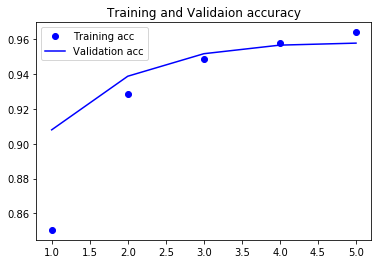

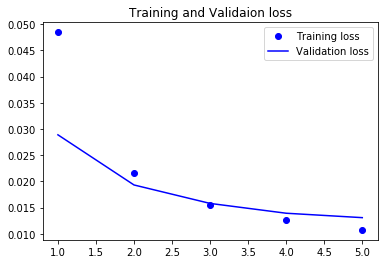

In [62]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [63]:
test_loss, test_acc = model3.evaluate(X_test, Y_test)

3684/3684 [==============================] - 6s 2ms/step


In [64]:
print("Test loss :", test_loss)
print("Test acc  :", test_acc)

Test loss : 0.014565746389793579
Test acc  : 0.9434277415275574


In [65]:
Y_pred = model3.predict(X_test)
Y_preds = np.argmax(Y_pred, axis = 2)

In [66]:
np.shape(np.argmax(Y_test, axis = 2))

(3684, 150)

In [67]:
Y_test_ = [y[y != 0.] for y in np.argmax(Y_test, axis = 2)]
Y_pred_ = [y_hat[y != 0.] for y, y_hat in zip(np.argmax(Y_test, axis = 2), Y_preds)]

In [68]:
print("True values      :", Y_test_[1])
print("Predicted values :", Y_pred_[1])

True values      : [9 9 5 9 9 9 9 8 9 9 9 9]
Predicted values : [9 9 5 9 9 9 9 5 9 9 9 9]


In [69]:
save("output3.txt", test_dict, ner, Y_test_, Y_pred_)